This notebook is for generating miscilaneous plots so that my other notebooks don't get too messy

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'
from classy import Class

#from pk_tools import pk_tools
sys.path.insert(1, '/home/joeadamo/Research/CovNet')
#sys.path.insert(1, "/users/JoeyA/Research/CovNet")
import src as CovNet
import src.CovaPT as CovaPT

base_dir = "/home/joeadamo/Research/CovNet/"

### Loss with respect to size of training set

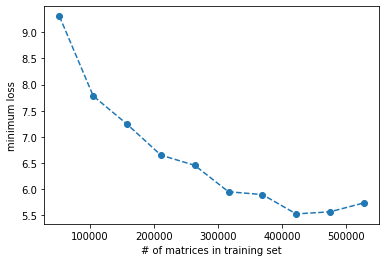

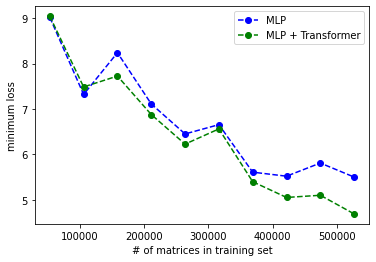

In [8]:
data_MLP = torch.load(base_dir+"emulators/ngc_z3/MLP/output_data_old.dat", map_location=torch.device("cpu"))
data_T = torch.load(base_dir+"emulators/ngc_z3/MLP-T/output_data.dat", map_location=torch.device("cpu"))

N = 526982
sizes = torch.Tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])

loss_data = data_MLP[0:10]
time_data = data_MLP[10:]
min_data = torch.min(loss_data, axis=1)
# the last few entries had a non-optimal batch size, so manually add in more recent, better runs
min_data[0][-1] = 5.74
min_data[0][-2] = 5.57
min_data[0][-3] = 5.53

plt.plot(sizes * N, min_data[0], ls="--", marker="o")
#plt.scatter(N, 5.79, marker="o", c="red")
plt.xlabel("# of matrices in training set")
plt.ylabel("minimum loss")

MLP_loss_data = torch.min(data_T[0:10][:,:,0], axis=1)[0]
T_loss_data = torch.min(data_T[0:10][:,:,1], axis=1)[0]

plt.figure()
#plt.plot(sizes * N, min_data[0], ls="--", marker="o")
plt.plot(sizes*N, MLP_loss_data, ls="--", marker="o", c="blue", label="MLP")
plt.plot(sizes*N, T_loss_data, ls="--", marker="o", c="green", label="MLP + Transformer")
plt.xlabel("# of matrices in training set")
plt.ylabel("minimum loss")
#plt.ylim(5.5, 9.5)
plt.legend()

## Attempt to recreate a version of Yosuke's plot  

from https://arxiv.org/pdf/2308.08593.pdf figure 1

[67.77    0.1184  1.      2.      0.      0.    ]
avg error per element (MLP)   = 3.161%
avg error per element (MLP-T) = 2.734%
[0.025 0.105 0.205 0.245]


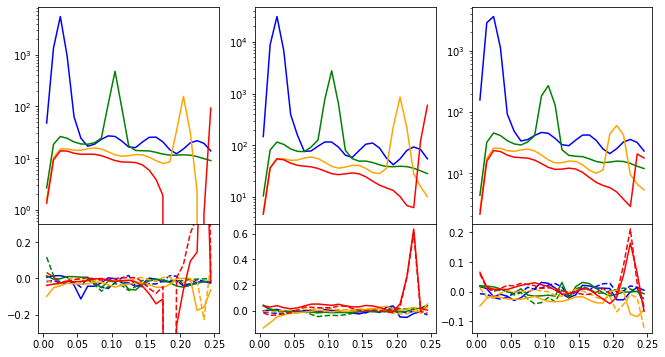

In [41]:
# load in "true" matrix
data = np.load("/home/joeadamo/Research/Software/Montepython/data/BOSS_DR12/Updated/Cov_Fid.npz")

C_True = data["C_G"] + data["C_NG"]
params = data["params"][:6]
print(params)

# load in the neural networks
num_blocks=5
patch_size=torch.Tensor([17,5]).int()
num_heads=5
Cov_Emulator_T = CovNet.Emulator.CovNet("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP-T/", 50, "MLP-T", num_blocks=num_blocks, patch_size=patch_size, num_heads=num_heads)
Cov_Emulator_MLP = CovNet.Emulator.CovNet("/home/joeadamo/Research/CovNet/emulators/ngc_z3/MLP/", 50, "MLP")

C_MLP = Cov_Emulator_MLP.get_covariance_matrix(params)
C_T = Cov_Emulator_T.get_covariance_matrix(params)

error_MLP = np.mean(abs((C_MLP / C_True) - 1))
error_T = np.mean(abs((C_T / C_True) - 1))

print("avg error per element (MLP)   = {:0.3f}%".format(100*error_MLP))
print("avg error per element (MLP-T) = {:0.3f}%".format(100*error_T))


k2 = np.linspace(0.005, 0.245, 25)
k1_idx = [2, 10, 20, 24]
print(k2[k1_idx])
colors = ["blue", "green", "orange", "red"]

fig, axs = plt.subplots(2, 3, figsize=(11, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

for i in range(len(k1_idx)):

    idx = k1_idx[i]
    axs[0, 0].plot(k2, k2 * k2[idx] * C_True[:25, :25][:, idx], c=colors[i])
    axs[0, 1].plot(k2, k2 * k2[idx] * C_True[25:, 25:][:, idx], c=colors[i])
    axs[0, 2].plot(k2, k2 * k2[idx] * C_True[:25, 25:][:, idx], c=colors[i])

    
    axs[1,0].plot(k2, (C_MLP[:25, :25][:,idx] / C_True[:25, :25][:, idx]) - 1, c=colors[i])
    axs[1,1].plot(k2, (C_MLP[25:, 25:][:,idx] / C_True[25:, 25:][:, idx]) - 1, c=colors[i])
    axs[1,2].plot(k2, (C_MLP[:25, 25:][:,idx] / C_True[:25, 25:][:, idx]) - 1, c=colors[i])

    axs[1,0].plot(k2, (C_T[:25, :25][:,idx] / C_True[:25, :25][:, idx]) - 1, ls="--", c=colors[i])
    axs[1,1].plot(k2, (C_T[25:, 25:][:,idx] / C_True[25:, 25:][:, idx]) - 1, ls="--", c=colors[i])
    axs[1,2].plot(k2, (C_T[:25, 25:][:,idx] / C_True[:25, 25:][:, idx]) - 1, ls="--", c=colors[i])

axs[0,0].set_yscale("log")
axs[0,1].set_yscale("log")
axs[0,2].set_yscale("log")
axs[1,0].set_ylim(-0.3, 0.3)
plt.subplots_adjust(hspace=0)